# Introduction
Understanding real time anomalies  in water level conditions is critical for decision makers in fields such as disaster preparedness and recovery, emergency responders, public safety, etc. Flagging 'abnormal' or outlier conditions in real time can significantly save lives and reduce property damage in high water scenarios. While outlier detection should be tailored to the specific use case, this accelerator notebooks aims to illustrate a few ways that customers can layer outlier detection methods, and alert notifications, on top of the data available in the Divirod data lake. 

Additionally, users may want to send automated alerts when the water level crosses a threshold boundary (say from 'normal' to 'high' or 'high' to 'extremely high'). Divirod advises implementing some version of an outlier detection method to filter out sending alerts that may be a result of faulty measurement readings or manual input errors on the side of the provider.

# Goal
The goal of this notebook is to demonstrate how users can implement outlier detection workflows on top of water level data in order to notify decision makers of the occurrence of abnormal water levels in real time. The examples in this notebook pull from Divirod's Water Level Index (WLI) - an in-house water risk scoring system. The WLI score is calculated each day and indicates where the latest water level measurement falls in relation to historical measurements from that gauge. This index can be used as an indicator for when current water levels are either extremely high or extremely low when compared to historical trends. The WLI interactive map and methodology document can be found [here](https://wli.divirod.com/).

The below graphic serves as a reference to where the content within this notebook sits in relation to Divirod's overall data ingestion pipeline. 


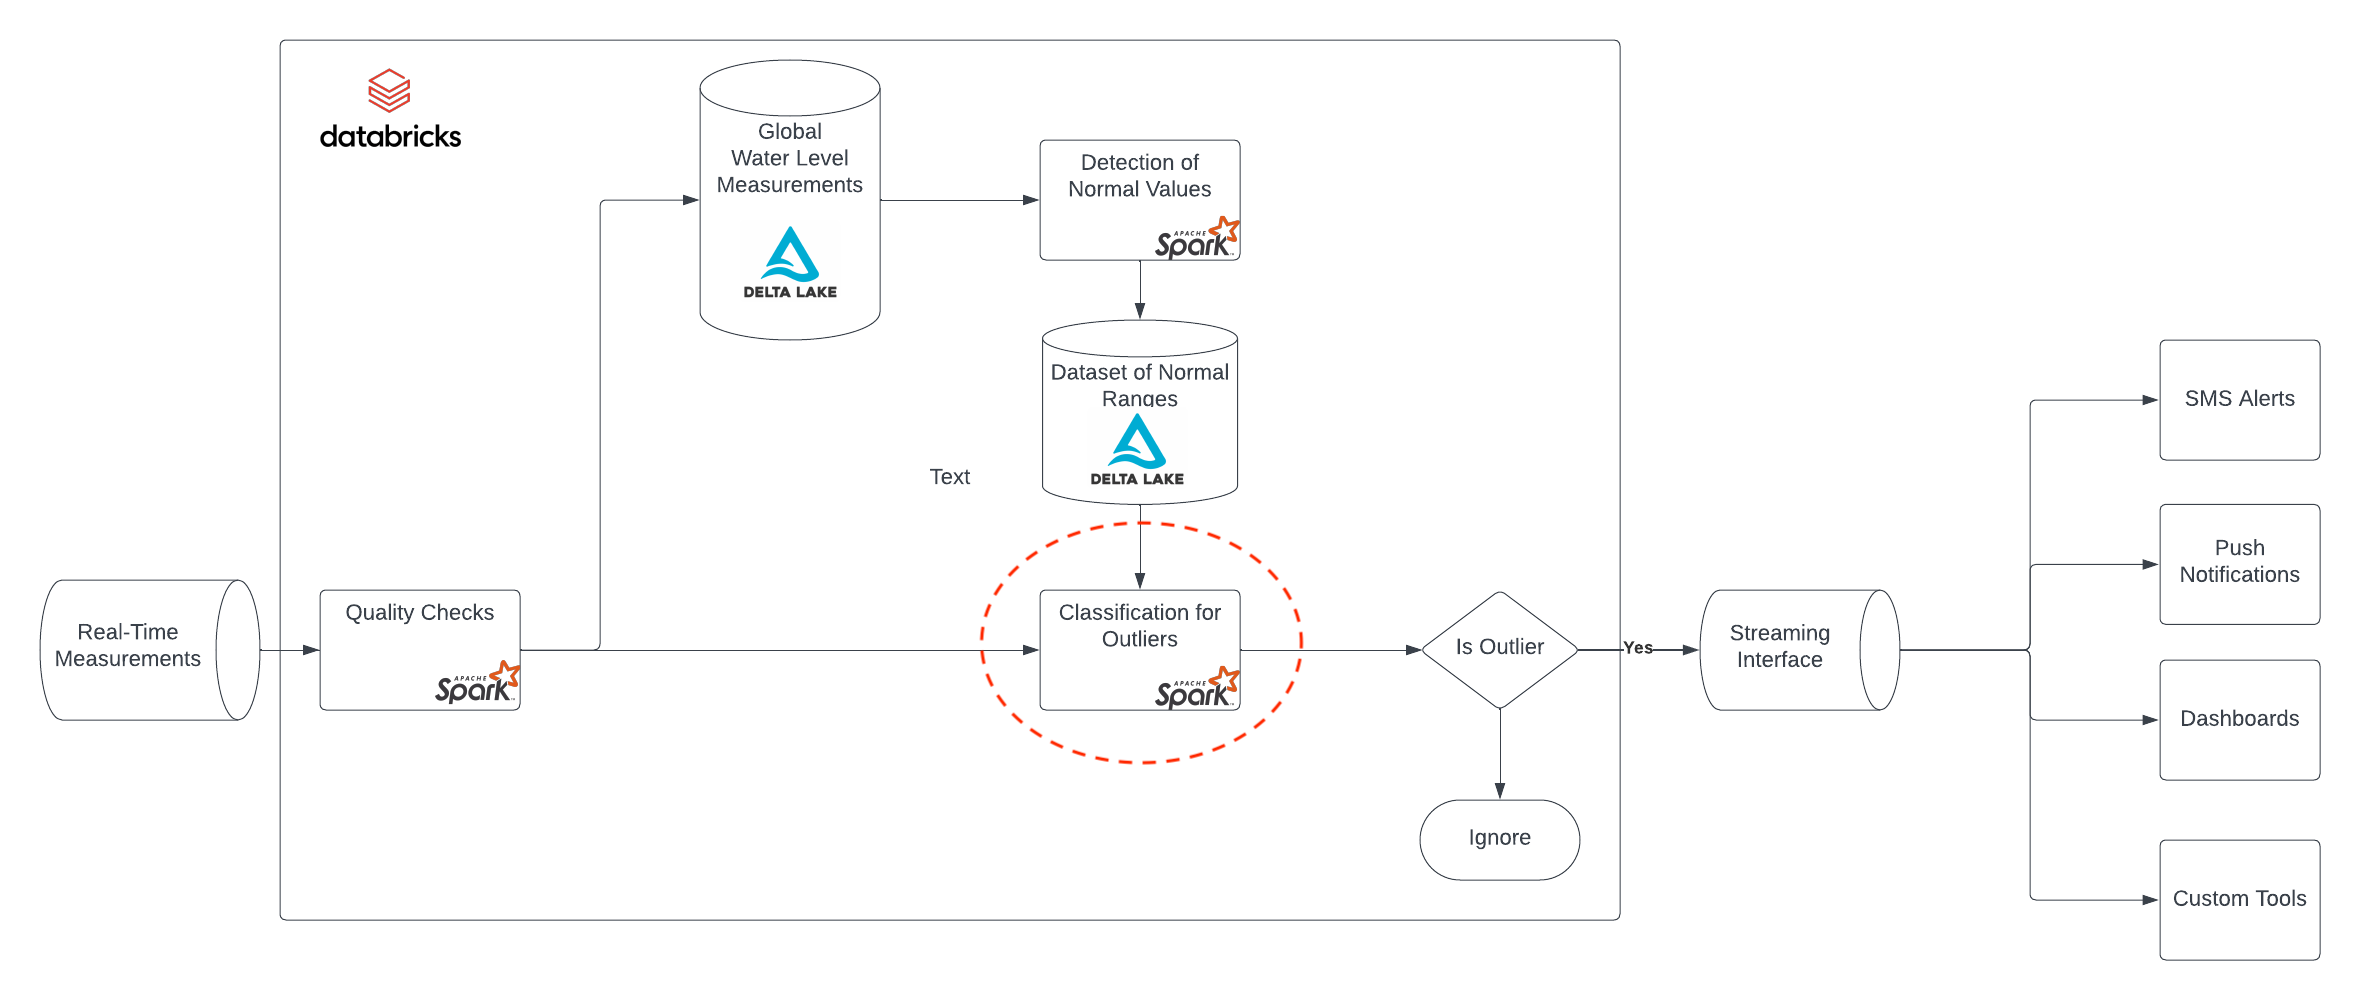

In [1]:
import base64
from IPython.display import HTML

image_path = './../images/architecture_diagram_outlier_classification.png'

# Function to get Base64 string of an image
def get_image_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_base64 = get_image_base64(image_path)

# Create an HTML string with the Base64 embedded and width set to 100%
html = f'<img src="data:image/jpg;base64,{image_base64}" style="width:100%;">'

# Display the image in the notebook
display(HTML(html))

# Example Workflow Explanation

### Outlier Detection Case 1
One potential outlier detection system may be classification. Building off the workflow outlined in the Solutions Accelerator Part 2 - Detection of Normal values, users may want to classify each daily average height and understand where it falls in relation to predefined threshold values. In our example, this would allow the user to know if daily water level conditions are 'extremely high', 'high', 'normal', 'low', or 'extremely low'. Understanding these daily conditions may be extremely useful for decision makers in operations... How full, or low, is my reservoir currently? Am I at risk of not having enough water available for daily cooling operations, etc. While the thresholds in this example are pre-defined, users can of course tailor their own threshold values to fit their needs.

Using this methodology, alert notifications could be sent out when these thresholds are crossed. For example, in the figure below, and alert notification could be sent the first time the water level crosses from 'high' to 'extremely' high to give decision makers notice that water levels are much higher than expected for that period of time. 


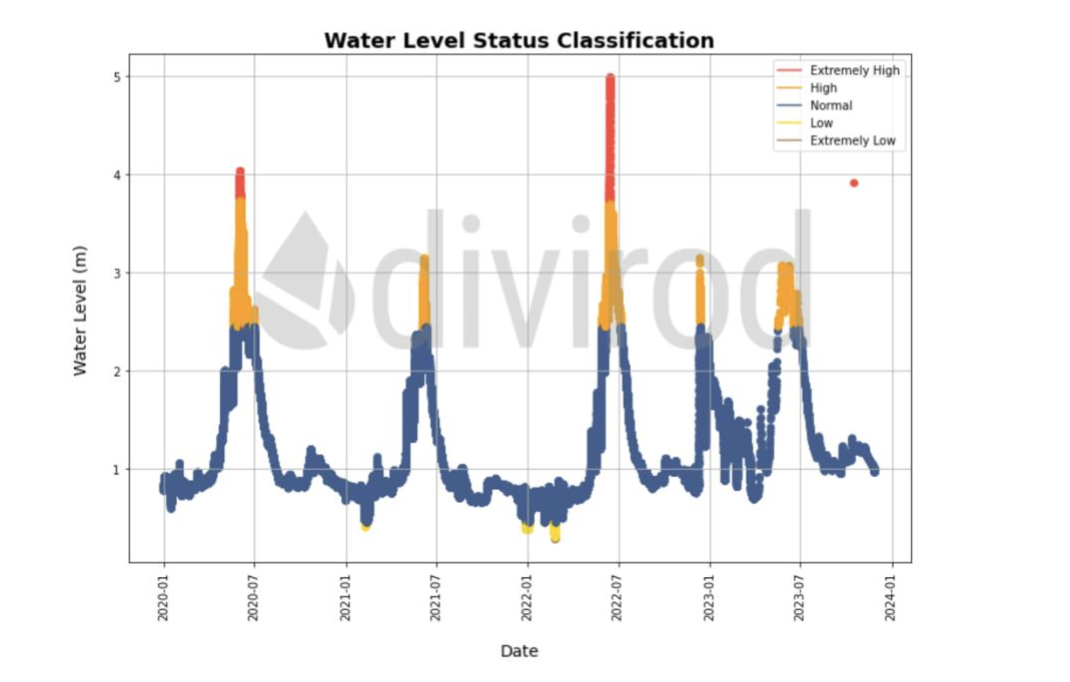

In [2]:
import base64
from IPython.display import HTML

image_path = './../images/river_classification_ex.png'

# Function to get Base64 string of an image
def get_image_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_base64 = get_image_base64(image_path)


html = f'<img src="data:image/jpg;base64,{image_base64}" style="width:60%; height: auto; display: block; margin: auto;">'


# Display the image in the notebook
display(HTML(html))

### Outlier Detection Case 2

# Code Example

## Imports

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType, BooleanType, TimestampType, IntegerType

import pandas as pd
import numpy as np
import datetime

import json


from pyspark.sql.window import Window
from pyspark.sql import dataframe as sparkDataFrame

## Read in Supporting Data

In [5]:
threshold_df = pd.read_csv('./../data/billings_thresholds.csv')

In [6]:
threshold_df

,Unnamed: 0,instrument_id,extreme_high_threshold,high_threshold,low_threshold,extreme_low_threshold
0,0,11074,1.495,1.009,-1.423,-0.937


In [7]:
# again, in reality, these would be referenced in a larger delta table in the delta lake with these values saved for each instrument id and re-calculated on a defined schedule as new data comes in
extreme_high_threshold = threshold_df['extreme_high_threshold'][0]
high_threshold = threshold_df['high_threshold'][0]
low_threshold = threshold_df['low_threshold'][0]
extreme_low_threshold = threshold_df['extreme_low_threshold'][0]

In [8]:
billings_2022_quality_checked_path = "./../data/billings_11074_all_measurements_2022_with_dq"

## Stream Configuration
This simulates our data stream coming out of our ETL pipeline - these same columns are present for all instruments in the data lake (both Divirod instruments, as well as third party).

In [ ]:
# define schema
billings_data_schema = StructType([
    StructField("instrument_id", IntegerType(), True),
    StructField("epoch", LongType(), True),
    StructField("time", TimestampType(), True),
    StructField("year", IntegerType(), True),
    StructField("height_native", DoubleType(), True),
    StructField("precision", DoubleType(), True),
    StructField("datum_native", StringType(), True),
    StructField("accuracy_native", DoubleType(), True),
    StructField("height_unified", DoubleType(), True),
    StructField("datum_unified", StringType(), True),
    StructField("accuracy_unified", DoubleType(), True),
    StructField("provider_id", IntegerType(), True),
    StructField("data_level", StringType(), True),
    StructField("confidence", DoubleType(), True),
    StructField("last_update", TimestampType(), True),
    StructField("last_update_epoch", LongType(), True),
    StructField("qualitative_metric", StringType(), True),
    StructField("diagnostic_metric", IntegerType(), True),
])

In [ ]:
# Read Parquet file as streaming DataFrame
simulated_data_stream = spark.readStream \
    .format("parquet") \
    .schema(billings_data_schema)\
    .load(billings_2022_quality_checked_path)

For this workflow, we are going to simulate daily average height values. The WLI uses daily average values for each gauge location to calculate the daily WLI index. More details on this process can be found in the methodology on the [WLI Map Page](https://wli.divirod.com/).

In [ ]:
# Group stream into daily averages (really, this would be done in SQL and not in the stream itself, this is just to simulate the automation in place for this process)
# Sort by time series order
daily_data_agg = simulated_data_stream \
    .groupBy(F.window(F.col("time"), "1 day")) \
    .agg(F.avg("height_native").alias("daily_height")) \
    .withColumn("date", F.col("window.start")) \
    .drop("window") \
    .orderBy("date")


## Outlier Detection
There are many ways users can implement outlier detection methods. Below are two potential workflows.

### Outlier Detection Case 1 - Classification Thresholds
Users can classify each daily average height and understand where it falls in relation to the predefined threshold values. This would allow the user to know if water level conditions are 'extremely high', 'high', 'normal', 'low', or 'extremely low'.


In [ ]:
def calculate_flag_outlier_categories(df:sparkDataFrame) -> sparkDataFrame:
  """
  Assigns a water level status to each entry in the DataFrame based on predefined threshold values for daily water heights.

  This function evaluates the 'daily_height' column in the input DataFrame and classifies each record into one of five categories: 'extreme_high', 'high', 'normal', 'low', or 'extreme_low'. The classification is based on comparison against the predefined thresholds.

  Parameters:
      df (sparkDataFrame): A Spark DataFrame containing at least a 'daily_height' column with numeric values representing daily water levels.

  Returns:
      sparkDataFrame: A DataFrame identical to the input but with an additional column 'water_level_status' indicating the water level category for each record.
  """
  df = df.withColumn(
    "water_level_status",
    F.when(F.col("daily_height") >= extreme_high_threshold, "extreme_high")
        .when(((F.col("daily_height") < extreme_high_threshold) & (F.col("daily_height") >= high_threshold)), "high")
        .when(F.col("daily_height") <= extreme_low_threshold, "extreme_low")
        .when(((F.col("daily_height") > extreme_low_threshold) & (F.col("daily_height") <= low_threshold)), "low")
        .otherwise("normal")
)
  return df

In [ ]:
# Apply function to streamed data set with transform
flag_outliers_case_1_df = daily_data_agg.transform(calculate_flag_outlier_categories)

In [ ]:
# Create temporary view to display results in this notebook
flag_outliers_case_1_df.createOrReplaceTempView('flag_outliers_case_1_table')

In [ ]:
%sql
-- Visualize data stream with assigned outlier classification values
SELECT * FROM flag_outliers_case_1_table

daily_height,date,water_level_status
0.41535349999999954,2022-01-01T00:00:00.000+0000,normal
0.41529000000000044,2022-01-02T00:00:00.000+0000,normal
0.47215425000000016,2022-01-03T00:00:00.000+0000,normal
0.4972685000000003,2022-01-04T00:00:00.000+0000,normal
0.6049327499999994,2022-01-05T00:00:00.000+0000,normal
0.6034405000000002,2022-01-06T00:00:00.000+0000,normal
0.6205537500000001,2022-01-07T00:00:00.000+0000,normal
0.6140449999999994,2022-01-08T00:00:00.000+0000,normal
0.6938644999999997,2022-01-09T00:00:00.000+0000,normal
0.7196455000000012,2022-01-10T00:00:00.000+0000,normal


### Outlier Detection Case 2
Another potential option for outlier detection could be to create user defined thresholds on the calculated Water Level Index (WLI)  values. Divirod's assigned WLI values range from -100 (extremely  low water level) to 100 (extremely high water level). Rather than using Divirod's built in water level classification system, users may want to define their own outlier detection method based on these WLI values.

This example assumes that the user wants to send an alert to decision makers when the defined threshold is crossed.

In [ ]:
def calculate_wli(df: sparkDataFrame) -> sparkDataFrame:
    """
    Calculates the WLI value for each daily height reading in the input dataset based on pre-defined extreme condition threshold values.

    Parameters:
        df (sparkDataFrame): A Spark DataFrame containing at least a 'daily_height' column with numeric values representing daily water levels.

    Returns:
        sparkDataFrame: A DataFrame identical to the input but with an additional column 'wli' indicating the water level index value for each record.
    """
    df = df.withColumn(
        "wli", (((F.col('daily_height')-extreme_low_threshold)/(extreme_high_threshold-extreme_low_threshold))*2 -1.0)*100
    )
    return df

In [ ]:
# define variables for WLI outliers (these should be defined based on customer needs)
HIGH_WLI_THRESHOLD = 90
LOW_WLI_THRESHOLD = -90

In [ ]:
def flag_outliers_based_on_user_thresholds(df: sparkDataFrame) -> sparkDataFrame:
    """
    Evaluates a 'wli' (water level index) column in a Spark DataFrame and flags each record based on user-defined thresholds for high and low water levels.

    This function checks the 'wli' value for each entry in the DataFrame and assigns an alert status in a new column 'alert'. Entries are flagged as 'Alert - High' if they meet or exceed a predefined high threshold (HIGH_WLI_THRESHOLD) or fall below a predefined low threshold (LOW_WLI_THRESHOLD). All other entries are marked as 'Normal'.

    Parameters:
        df (sparkDataFrame): A Spark DataFrame containing at least a 'wli' column with numeric values.

    Returns:
        sparkDataFrame: A DataFrame similar to the input but with an additional 'alert' column showing the alert status for each record.
    """

    df = df.withColumn(
    "alert",
        F.when(F.col("wli") >= HIGH_WLI_THRESHOLD, "Alert - High")
            .when(F.col("wli") <= LOW_WLI_THRESHOLD, "Alert - High")
            .otherwise("Normal")
    )
    return df

In [ ]:
# Apply wli calculation to streamed data set with transform 
daily_agg_wli = daily_data_agg.transform(calculate_wli)

In [ ]:
# Apply outlier detection to streamed data set with transform 
flag_outliers_case_2_df = daily_agg_wli.transform(flag_outliers_based_on_user_thresholds)

In [ ]:
# Create temporary view to display results in this notebook
flag_outliers_case_2_df.createOrReplaceTempView('flag_outliers_case_2_table')

In [ ]:
%sql
-- Visualize data stream with calculated wli values and alert notification
SELECT * FROM flag_outliers_case_2_table

daily_height,date,wli,alert
0.41535349999999954,2022-01-01T00:00:00.000+0000,11.213281249999941,Normal
0.41529000000000044,2022-01-02T00:00:00.000+0000,11.208059210526343,Normal
0.6049327499999994,2022-01-05T00:00:00.000+0000,26.803680098684147,Normal
0.6034405000000002,2022-01-06T00:00:00.000+0000,26.68096217105265,Normal
0.6938644999999997,2022-01-09T00:00:00.000+0000,34.1171463815789,Normal
0.7196455000000012,2022-01-10T00:00:00.000+0000,36.23729440789481,Normal
0.736727000000001,2022-01-12T00:00:00.000+0000,37.642023026315854,Normal
0.7302499999999997,2022-01-13T00:00:00.000+0000,37.10937499999996,Normal
0.7416165000000013,2022-01-16T00:00:00.000+0000,38.04412006578956,Normal
0.7282815000000005,2022-01-17T00:00:00.000+0000,36.94749177631582,Normal
